In [1]:
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchaudio.transforms import Resample
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(f'torch.cuda.is_available: {torch.cuda.is_available()}')
print(f'torch.backends.cudnn.enabled: {torch.backends.cudnn.enabled}')
print(torch.backends.cudnn.version())

2.1.2
torch.cuda.is_available: True
torch.backends.cudnn.enabled: True
8902


Dataset

In [ ]:
import os
import h5py

class MultiHDF5SpectrogramDataset(Dataset):
    def __init__(self, hdf5_path):
        
        self.hdf5_paths = hdf5_paths
        self.keys = []
        self.file_indices = []
        for idx, file_path in enumerate(hdf5_paths):
            with h5py.File(file_path, 'r') as file:
                keys = list(file.keys())
                print(f'keys = {keys}')
                self.keys.extend(keys)
                self.file_indices.extend([idx] * len(keys))
        self.label_mapping = {
            'C major': 0, 'A minor': 0,
            'C# major': 1, 'D♭ major': 1, 'A# minor': 1, 'B♭ minor': 1,
            'D major': 2, 'B minor': 2,
            'E♭ major': 3, 'D# major': 3, 'C minor': 3,
            'E major': 4, 'C# minor': 4, 'D♭ minor':4,
            'F major': 5, 'D minor': 5,
            'F# major': 6, 'G♭ major': 6, 'D# minor': 6, 'E♭ minor': 6,
            'G major': 7, 'E minor': 7,
            'A♭ major': 8, 'G# major': 8, 'F minor': 8,
            'A major': 9, 'F# minor': 9, 'G♭ minor': 9,
            'B♭ major': 10, 'A# major': 10, 'G minor': 10,
            'B major': 11, 'G# minor': 11, 'A♭ minor': 11
        }
    
    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        file_idx = self.file_indices[idx]
        key = self.keys[idx]
        with h5py.File(self.hdf5_paths[file_idx], 'r') as file:
            data = torch.tensor(file[key][:], dtype=torch.float32)
            label_str = file[key].attrs['label']
            mapped_label = self.label_mapping[label_str]
            label_tensor = torch.tensor(mapped_label, dtype=torch.long)

        # get file name
        file_name = os.path.basename(self.hdf5_paths[file_idx]) + ':' + key

        return data, label_tensor, file_name
    

# Usage
# dataset = HDF5SpectrogramDataset('/media/data/wren/GTZAN_dataset/pop/mel_spectrograms.hdf5')
# hdf5_paths = ['path/to/your/file1.hdf5', 'path/to/your/file2.hdf5', 'path/to/another/file3.hdf5']
# dataset = MultiHDF5SpectrogramDataset(hdf5_paths)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)



Model Architecture

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split, Sampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchaudio.transforms import Resample
import torch.nn as nn
import torch.nn.functional as F

class KeyEstimationCNN(nn.Module):
    def __init__(self):
        super(KeyEstimationCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(8)
        self.conv5 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, padding=2)
        self.bn5 = nn.BatchNorm2d(8)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # 计算全连接层的输入尺寸
        self._calculate_flatten_size()
        
        self.fc1 = nn.Linear(self.flatten_size, 48)
        self.bn_fc1 = nn.BatchNorm1d(48)
        self.fc2 = nn.Linear(48, 12)
        self.bn_fc2 = nn.BatchNorm1d(12)

        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        
    def _calculate_flatten_size(self):
        # 假设输入尺寸为 [1, 84, 937]
        sample_input = torch.zeros(1, 1, 103, 175)
        # sample_input = torch.zeros(1, 1, 84, 175)
        sample_output = self._forward_conv_layers(sample_input)
        self.flatten_size = sample_output.view(1, -1).size(1)

    def _forward_conv_layers(self, x):
        x = self.pool(F.elu(self.bn1(self.conv1(x))))
        x = self.pool(F.elu(self.bn2(self.conv2(x))))
        x = self.pool(F.elu(self.bn3(self.conv3(x))))
        x = self.pool(F.elu(self.bn4(self.conv4(x))))
        x = self.pool(F.elu(self.bn5(self.conv5(x))))
        return x
        
    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # 展平为一维向量
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.elu(x)
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.softmax(x, dim=1)
        return x


# # test model architecture
# num_classes = 24  # 24 keys
# dummy_input = torch.randn(64, 1, 103, 600)
# model = KeyEstimationCNN(num_classes=num_classes)
# dummy_output = model(dummy_input)
# print(dummy_output.shape)  # shold be (64, num_classes)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def calculate_mirex_scores(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    total = targets.size(0)

    # Correct (rc)
    rc = (predicted == targets).sum().item() / total

    # Perfect fifth
    fifth_mapping = {
        0: [7],    # C major & A minor -> G major, E minor
        1: [8],    # C# major & D♭ major, A# minor & B♭ minor -> G# major, E♭ minor (G# minor), F minor
        2: [9],    # D major & B minor -> A major, F# minor
        3: [10],  # E♭ major, D# major, C minor -> B♭ major, G minor
        4: [11],  # E major, C# minor, D♭ minor -> B major, G# minor (A♭ minor)
        5: [0],    # F major & D minor -> C major, A minor
        6: [1],    # F# major, G♭ major, D# minor, E♭ minor -> C# major, B♭ minor (D# minor), A# minor
        7: [2],    # G major & E minor -> D major, B minor
        8: [3],    # A♭ major, G# major, F minor -> E♭ major, C minor
        9: [4],    # A major, F# minor, G♭ minor -> E major, C# minor (G♭ minor)
        10: [5],   # B♭ major, A# major, G minor -> F major, D minor
        11: [6]    # B major, G# minor, A♭ minor -> F# major, D# minor
    }

    # Parallel key
    parallel_mapping = {
        0: [3, 9],    # C major & A minor -> C minor, A major
        1: [4, 10],   # C# major & D♭ major, A# minor & B♭ minor -> C# minor, A# major
        2: [5, 11],   # D major & B minor -> D minor, B major
        3: [0, 6],    # E♭ major, D# major, C minor -> C major, E♭ minor
        4: [7, 1],    # E major, C# minor, D♭ minor -> E minor, C# major
        5: [2, 8],    # F major & D minor -> D major, F minor
        6: [9, 3],    # F# major, G♭ major, D# minor, E♭ minor -> F# minor, E♭ major
        7: [10, 4],   # G major & E minor -> G minor, E major
        8: [5, 11],   # A♭ major, G# major, F minor -> F major, A♭ minor
        9: [0, 6],    # A major, F# minor, G♭ minor -> A minor, F# major
        10: [7, 1],   # B♭ major, A# major, G minor -> G major, B♭ minor
        11: [2, 8]    # B major, G# minor, A♭ minor -> B minor, A♭ major
    }


    # Fifth (rf)
    rf = sum(any(pred == ft for ft in fifth_mapping.get(t.item(), [])) for pred, t in zip(predicted, targets)) / total

    # Parallel (rp)
    rp = sum(any(pred == pt for pt in parallel_mapping.get(t.item(), [])) for pred, t in zip(predicted, targets)) / total

    # Relative Minor/Major (rr) and Parallel Minor/Major (rp)
    rr = 0  # default to zero since Relative Minor/Major and Parallel Minor/Major are merged into the same classes

    # compute weighted score
    weighted_score = rc + 0.5 * rf + 0.2 * rp

    return weighted_score, rc, rf, rr, rp


def validate_model(model, val_loader, criterion, mirex=True):
    model.eval()
    total_accuracy = 0
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            # print(f'val targets: {targets}')
            # print(f'val predicted: {preds}\n')

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

            w, rc, rf, rr, rp = calculate_mirex_scores(outputs, targets)
            if mirex == True:
                total_accuracy += w
            else:
                total_accuracy += rc

    # # Plot confusion matrix
    # cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.xlabel('Predicted Labels')
    # plt.ylabel('True Labels')
    # plt.title('Confusion Matrix')
    # plt.show()
    
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)

    return avg_loss, avg_accuracy, all_preds, all_labels




測試 Model 的函式

In [ ]:
import re

def split_key_mode(label):
    key, mode = label.split()
    return key, mode

def extract_number(file_name):
    match = re.search(r'(\d+)(?!.*\d)', file_name)
    return int(match.group(1)) if match else float('inf')

def sort_key(file_name):
    if "instrument_estimated" in file_name:
        prefix = 0
    elif "second_time" in file_name:
        prefix = 1
    else:
        prefix = 2
    number = extract_number(file_name)
    return (prefix, number)

def test_model(model, test_loader, reverse_label_mapping, criterion, mirex=False):
    model.eval()
    total_accuracy = 0
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_file_names = []
    results = []

    with torch.no_grad():
        for data, targets, file_names in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)

            print(f'targets: {targets}')
            print(f'predicted: {preds}\n')

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_file_names.extend(file_names)

            w, rc, rf, rr, rp = calculate_mirex_scores(outputs, targets)
            if mirex == True:
                total_accuracy += w
            else:
                total_accuracy += rc

            # save results
            for file_name, true_label, pred_label in zip(file_names, targets.cpu().numpy(), preds.cpu().numpy()):
                true_key, true_mode = split_key_mode(reverse_label_mapping[true_label])
                pred_key, pred_mode = split_key_mode(reverse_label_mapping[pred_label])
                results.append([file_name, true_key, true_mode, pred_key, pred_mode])

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader)

    # plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix on Test Set')
    plt.show()

    # separatly process "instrument_estimated (first)" and "second_time (second)" 
    instrument_estimated_results = [result for result in results if "instrument_estimated" in result[0]]
    second_time_results = [result for result in results if "second_time" in result[0]]
    other_results = [result for result in results if "instrument_estimated" not in result[0] and "second_time" not in result[0]]

    # sorted by number
    instrument_estimated_results.sort(key=lambda x: extract_number(x[0]))
    second_time_results.sort(key=lambda x: extract_number(x[0]))
    other_results.sort(key=lambda x: extract_number(x[0]))

    # merge sorted files
    sorted_results = instrument_estimated_results + second_time_results + other_results

    # save as excel file
    df = pd.DataFrame(sorted_results, columns=['File Name', 'True Key', 'True Mode', 'Predicted Key', 'Predicted Mode'])
    df.to_excel('test_results.xlsx', index=False)
    print(f'test_results.xlsx saved.')

    return avg_loss, avg_accuracy, all_preds, all_labels

Load dataset

keys = ['instrument_estimated_1.wav_padded', 'instrument_estimated_10.wav_padded', 'instrument_estimated_11.wav_padded', 'instrument_estimated_12.wav_padded', 'instrument_estimated_13.wav_padded', 'instrument_estimated_14.wav_padded', 'instrument_estimated_15.wav_padded', 'instrument_estimated_16.wav_padded', 'instrument_estimated_17.wav_padded', 'instrument_estimated_18.wav_padded', 'instrument_estimated_19.wav_padded', 'instrument_estimated_2.wav_padded', 'instrument_estimated_20.wav_padded', 'instrument_estimated_21.wav_padded', 'instrument_estimated_22.wav_padded', 'instrument_estimated_23.wav_padded', 'instrument_estimated_24.wav_padded', 'instrument_estimated_25.wav_padded', 'instrument_estimated_26.wav_padded', 'instrument_estimated_27.wav_padded', 'instrument_estimated_28.wav_padded', 'instrument_estimated_29.wav_padded', 'instrument_estimated_3.wav_padded', 'instrument_estimated_30.wav_padded', 'instrument_estimated_31.wav_padded', 'instrument_estimated_32.wav_padded', 'instru

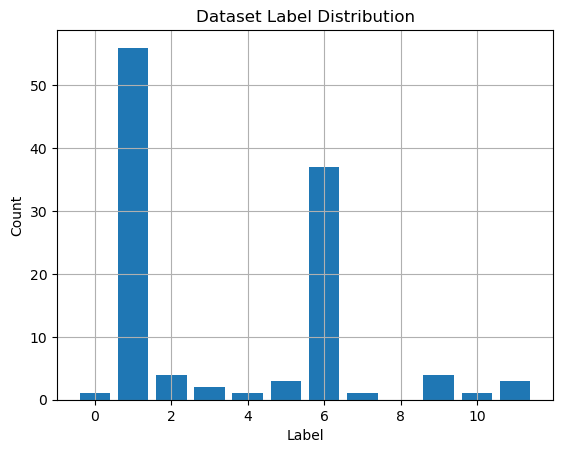

total size: 113


In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_label_distribution(dataset, title='Dataset Label Distribution'):
    label_counts = defaultdict(int)
    for _, label, _ in dataset:
        label_counts[label.item()] += 1
    
    labels, counts = zip(*sorted(label_counts.items()))
    plt.bar(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(title)
    plt.grid()
    plt.show()


hdf5_paths = [
    'test_log_spectrograms_rtk.hdf5'
    # 'test_log_spectrograms_30sec.hdf5'
]
dataset = MultiHDF5SpectrogramDataset(hdf5_paths)
plot_label_distribution(dataset)
total_size = len(dataset)
print(f'total size: {total_size}')

test_loader = DataLoader(dataset, batch_size=1, shuffle=False)


Create Model

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: ten

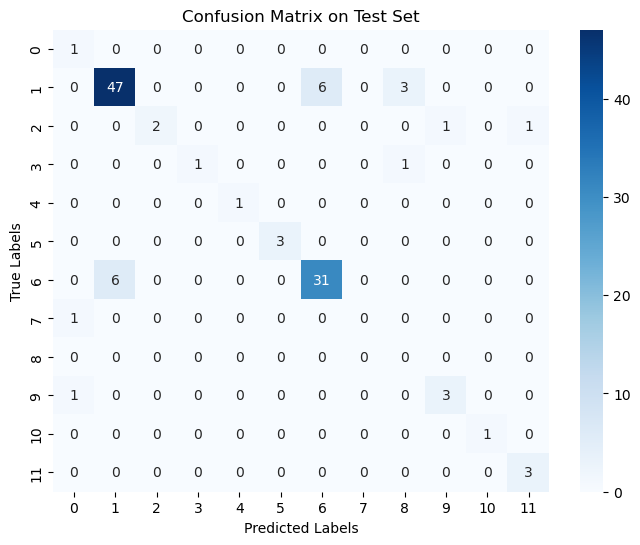

test_results.xlsx saved.
Test Loss: 1.815655991039445, Test Accuracy: 0.8230088495575221


In [ ]:
# Initialize model and move to GPU
model = KeyEstimationCNN().to(device)

# checkpoint = torch.load('best_tonality_model_12_mix_genre.pth')
checkpoint = torch.load('best_tonality_model_rtk.pth')
model_state_dict = checkpoint['model_state_dict']
model.load_state_dict(model_state_dict)
model.eval()

# Loss function
criterion = nn.CrossEntropyLoss()

reverse_label_mapping = {v: k for k, v in dataset.label_mapping.items()}
test_loss, test_accuracy, test_preds, test_labels = test_model(model, test_loader, reverse_label_mapping, criterion, mirex=False)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([6], device='cuda:0')

targets: tensor([6], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: tensor([1], device='cuda:0')

targets: tensor([1], device='cuda:0')
predicted: ten

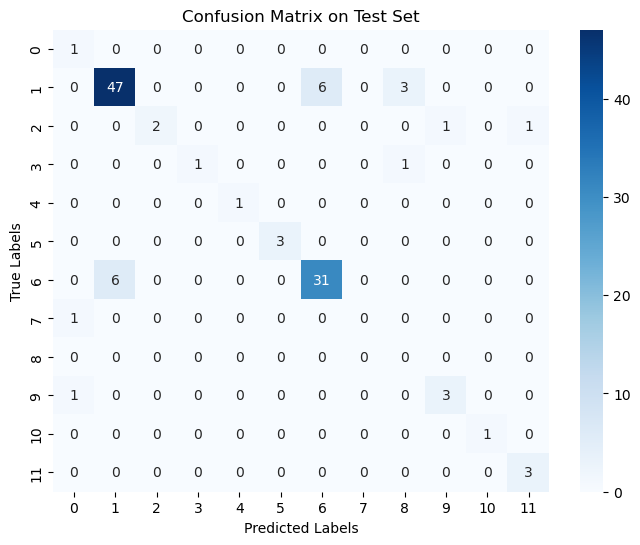

test_results.xlsx saved.
Test Loss: 1.815655991039445, MIREX Test Accuracy: 0.8707964601769912


In [9]:
test_loss, test_accuracy, test_preds, test_labels = test_model(model, test_loader, reverse_label_mapping, criterion, mirex=True)
print(f"Test Loss: {test_loss}, MIREX Test Accuracy: {test_accuracy}")

